In [2]:
import tensorflow as tf
import importlib
import os
import loss_functions
import dataprocessor
import model
import pickle
import change_point_detection
from tqdm import tqdm
from heartrate import trace

def reload_custom_libs():
    importlib.reload(loss_functions)
    importlib.reload(dataprocessor)
    importlib.reload(change_point_detection)
    importlib.reload(model)



reload_custom_libs()
from change_point_detection import *
from loss_functions import *
from model import *
from dataprocessor import *

macd_timescales = [(8, 24), (16, 28), (32, 96)]
rtn_timescales = [1, 21, 63, 126, 252]
timesteps = 126
folder_path = "data"
files = [f for f in os.listdir(folder_path) if f.endswith(".csv")][:10]

In [3]:
# 获得高斯变点片段
# test = (20080101, 20090101)
gaussion_process_list = []
# for i in tqdm(range(15)):
#     first_date, last_date = (test[0] + 10000 * i, test[1] + 10000 * i)
#     # 处理数据
#     data_list = process_data_list(files, macd_timescales, rtn_timescales, first_date=first_date, last_date=last_date)
#     print(f"{first_date}_{last_date}数据处理完成")
#     # 获得断点分割片段数据
#     try:
#         gaussion_process_list = get_segment_list(data_list=data_list)
#     except:
#         continue
#     with open(f'segments/{first_date}_{last_date}.pkl', 'wb') as f:
#         pickle.dump(gaussion_process_list, f)
#     # # 读取数据
#     # with open(f'segments/{first_date}_{last_date}.pkl', 'rb') as f:
#     #     file = pickle.load(f)
#     #     gaussion_process_list.extend(file)


data_list, fill_list = process_data_list(files, macd_timescales, rtn_timescales, first_date=20200101, fill=True)
date_list = pd.to_datetime(data_list[0]["date"], format='%Y%m%d')

pkl_files = [f for f in os.listdir("segments") if f.endswith(".pkl")]
for file in pkl_files:
    with open("segments/" + file, 'rb') as file:
        data = pickle.load(file)
        gaussion_process_list.extend(data)


# 预测数据预处理

In [4]:
reload_custom_libs()
from change_point_detection import *
from loss_functions import *
from model import ModelWrapper
from dataprocessor import *


In [5]:
# 生成数据： target_set 和 context_set
asset_num, context_num = 10, 20
with open(f'map.pkl', 'rb') as f:
    word_index = pickle.load(f)
target_set, labels, word_index = generate_tensors(data_list, time_steps=timesteps, encoder_type = "one-hot", word_index = word_index, return_map=True)
target_set, context_set, labels = gaussian_data_binder(
    data_list,
    target_set,
    labels,
    map=word_index,
    asset_num=asset_num,
    context_num=context_num,
    gaussion_process_list=gaussion_process_list,
)

# 设置参数
target_std = tf.cast(5e-2, tf.float64)
hidden_dim = 64  # 128
warm_up = 63
features_len = len(macd_timescales) + len(rtn_timescales)

生成张量, 并对类别信息进行one-hot 编码:   0%|          | 0/10 [00:00<?, ?it/s]

生成张量, 并对类别信息进行one-hot 编码: 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]


one-hot 编码中...


# 预测模型初始化

In [7]:
x, s, labels = target_set[0], target_set[-1], labels
batch_size = 60
x_c_rtn, x_c, s_c = context_set[0], context_set[0][:, :, :, 1:], context_set[-1]
dataset = tf.data.Dataset.from_tensor_slices((x_c, x_c_rtn, s_c, x, s, labels))
dataset = dataset.batch(batch_size, drop_remainder=False)

timesteps = x.shape[-2]
features_len = x.shape[-1]
encoding_size = s.shape[-1]
x_shape = (None, asset_num, timesteps, features_len)
s_shape = (None, asset_num, timesteps, encoding_size)

xtrend_model = ModelWrapper(features_len, hidden_dim, encoding_size, num_heads=4, dropout_rate=0.4)
xtrend_model.build((x_shape, s_shape))
xtrend_model.load_weights('model/1_loss_-0.42.keras')

# 进行预测

In [8]:
all_properties = []
all_positions = []
fill_list = fill_list

# 进行预测
for batch in tqdm(dataset):
    x_c_batch, x_c_rtn_batch, s_c_batch, x_batch, s_batch, labels_batch = batch
    properties, positions = xtrend_model(x_c_batch, x_c_rtn_batch, s_c_batch, x_batch, s_batch)
    all_properties.append(properties)
    all_positions.append(positions)

100%|██████████| 17/17 [00:59<00:00,  3.50s/it]


In [ ]:
# all_properties = []
# all_positions = []
# fill_list = fill_list

# # 进行预测
# for batch in tqdm(dataset):
#     x_c_batch, x_c_rtn_batch, s_c_batch, x_batch, s_batch, labels_batch = batch
#     properties, positions = xtrend_model(x_c_batch, x_c_rtn_batch, s_c_batch, x_batch, s_batch)
#     all_properties.append(properties)
#     all_positions.append(positions)
    
#     mask_properties = tf.constant([i not in fill_list for i in range(all_positions_tensor.shape[-1])])
#     print(positions.shape)
#     _positions_tensor = tf.boolean_mask(positions, mask_properties, axis=1)
#     _labels_tensor = tf.boolean_mask(labels_batch, mask_properties, axis=1)

#     v = sharpe_loss(
#         _positions_tensor,
#         _labels_tensor,
#         target_std,
#         warm_up=warm_up,
#     )
#     print(v)

In [9]:
# 将所有的预测结果合并成一个tensor, 只取最后一个时间步作为下一日的预测输出
all_properties_tensor = tf.concat(all_properties, axis=0)[:, :, -1, :]
all_positions_tensor = tf.reduce_mean(tf.concat(all_positions, axis=0), axis=-1)
all_labels = labels[:, :, -1, :]
mask_properties = tf.constant([i not in fill_list for i in range(all_positions_tensor.shape[-1])])

# 取特征和持仓，并过滤掉不可以使用的资产
filtered_properties_tensor = tf.boolean_mask(all_properties_tensor, mask_properties, axis=-2)
filtered_positions_tensor = tf.boolean_mask(all_positions_tensor, mask_properties, axis=1)
filtered_labels_tensor = tf.boolean_mask(all_labels, mask_properties, axis=1)
filtered_rtn = filtered_labels_tensor[:, :, 0]

# 输出合并后的tensor
print("Properties Tensor Shape:", filtered_properties_tensor.shape)
print("Positions Tensor Shape:", filtered_positions_tensor.shape)
print("labels Tensor Shape:", filtered_labels_tensor.shape)
print("rtn Tensor Shape:", filtered_rtn.shape)

Properties Tensor Shape: (969, 9, 2)
Positions Tensor Shape: (969, 9)
labels Tensor Shape: (969, 9, 2)
rtn Tensor Shape: (969, 9)


In [10]:
reload_custom_libs()
from change_point_detection import *
from loss_functions import*
from model import ModelWrapper
from dataprocessor import *

In [15]:
filtered_positions_tensor

<tf.Tensor: shape=(969, 9), dtype=float64, numpy=
array([[-0.85183107, -0.85183857, -0.85186229, ..., -0.8517816 ,
        -0.85185014, -0.85182372],
       [-0.85183468, -0.85184187, -0.85186521, ..., -0.85178634,
        -0.85185324, -0.85182728],
       [-0.85182961, -0.85183721, -0.85186118, ..., -0.85177975,
        -0.85184897, -0.85182241],
       ...,
       [-0.85183483, -0.8518403 , -0.8518641 , ..., -0.8517828 ,
        -0.85185385, -0.85182494],
       [-0.85183044, -0.85183595, -0.85186058, ..., -0.85177659,
        -0.85185021, -0.85182021],
       [-0.85183313, -0.85183853, -0.85186276, ..., -0.85178037,
        -0.85185244, -0.85182315]])>

In [11]:
rtn_tensor = filtered_rtn * filtered_positions_tensor
portfolio_rtn_tensor = tf.reduce_sum(rtn_tensor, axis=1)
portfolio_rtn_numpy = (1 + portfolio_rtn_tensor.numpy()).cumprod()

In [12]:
portfolio_rtn_series = pd.Series(portfolio_rtn_numpy, index=date_list[-portfolio_rtn_numpy.shape[0]:].reset_index()["date"])
portfolio_rtn_tensor.numpy().mean() / portfolio_rtn_tensor.numpy().std()


-0.021422958721523926

<Axes: xlabel='date'>

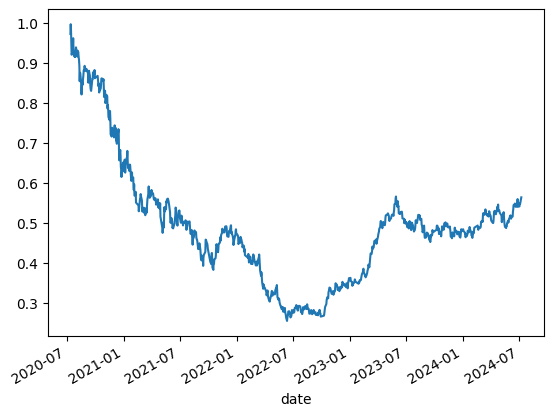

In [13]:
portfolio_rtn_series = pd.Series(portfolio_rtn_numpy, index=date_list[-portfolio_rtn_numpy.shape[0]:].reset_index()["date"])
portfolio_rtn_series.plot()


In [14]:
portfolio_rtn_series

date
2020-07-13    0.973342
2020-07-14    0.997515
2020-07-15    0.981334
2020-07-16    0.946945
2020-07-17    0.921210
                ...   
2024-07-03    0.541888
2024-07-04    0.549753
2024-07-05    0.547659
2024-07-08    0.560657
2024-07-09    0.564503
Length: 969, dtype: float64